In [ ]:
import numpy as np
import pandas as pd
import gzip
import os
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.manifold import TSNE
import random
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from skimage import color
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
import cv2
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,RocCurveDisplay,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import time


In [ ]:
def generate_dataset(size,mode):
    if mode == 0: #Simple Ruling data generation
      x = []
      y = []
      target = []
      for i in range(size):
          # class zero
          x.append(np.round(random.uniform(0, 2.5), 1))
          y.append(np.round(random.uniform(0, 20), 1))
          target.append(0)
          # class one
          x.append(np.round(random.uniform(1, 5), 2))
          y.append(np.round(random.uniform(15, 25), 2))
          target.append(1)

    elif mode == 1: #Gaussian Quantiles
        X1, t1 = make_gaussian_quantiles(cov=3.,n_samples=size, n_features=2,n_classes=2, random_state=1)

        X1 = pd.DataFrame(X1,columns=['x','y'])
        x = X1["x"]
        x=x.to_numpy()
        y = X1["y"]
        y=y.to_numpy()
        t1 = pd.Series(t1)
        target=t1.to_numpy()

    elif mode == 2: #Blobs
        X,t1 = make_blobs(n_samples=size, centers=2, n_features=2,random_state=17)

        X = pd.DataFrame(X,columns=['x','y'])
        x = X["x"]
        x=x.to_numpy()
        y = X["y"]
        y=y.to_numpy()
        t1 = pd.Series(t1)
        target=t1.to_numpy()  
    elif mode == 3: #Make classification API
        X,t1 = make_classification(n_samples=size, n_features=2,n_classes=2, n_informative=2, 
                    n_redundant=0, n_repeated=0, n_clusters_per_class= 1,class_sep=0.5,weights=[0.5,0.5])

        x = X[:,0]
        y = X[:,1]
        target = t1
    elif mode == 4: #Make moon
        X,t1 = make_moons(size,noise=0.1)
        X = pd.DataFrame(X,columns=['x','y'])
        x = X["x"]
        x=x.to_numpy()
        y = X["y"]
        y=y.to_numpy()
        t1 = pd.Series(t1)
        target=t1.to_numpy()  

    return x,y,target

In [ ]:
def show_metric(y_test,Predicted_labels):
  
    confu = confusion_matrix(y_test,Predicted_labels,labels=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=confu,display_labels=["0","1"])
    disp.plot()
    ACC = accuracy_score(y_test,Predicted_labels)
    Rec = recall_score(y_test,Predicted_labels)
    Precision = precision_score(y_test,Predicted_labels)
    f1score = f1_score(y_test,Predicted_labels)
    print("ACC is :",ACC ,"\nRec is :",Rec,"\nPersision is : ",Precision,"\nF1 Score is :",f1score)

In [ ]:
def show_linear_decision(clf,y,f1,f2):

  for i in range(len(y)):
    if y[i] == 0:
      plt.scatter(f1[i],f2[i],s=2,color = 'red')
    else:
      plt.scatter(f1[i],f2[i],s=2,color = 'blue')

  w = clf.coef_[0]           # w consists of 2 elements
  b = clf.intercept_[0]      # b consists of 1 element
  x_points = np.linspace(-10, 10)    # generating x-points from -1 to 1
  y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
  # Plotting a red hyperplane
  plt.plot(x_points, y_points, c='r');



In [ ]:
def polynomial_kernel(X, Y, degree=3, gamma=1, coef0=1):
    """
    Polynomial kernel implementation for SVM using NumPy.
    
    Args:
        X (ndarray): Input data with shape (n_samples_X, n_features).
        Y (ndarray): Input data with shape (n_samples_Y, n_features).
        degree (int): Degree of the polynomial kernel function.
        gamma (float): Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
        coef0 (float): Independent term in kernel function. It is only significant
            in 'poly' and 'sigmoid'.
        
    Returns:
        K (ndarray): Computed kernel matrix with shape (n_samples_X, n_samples_Y).
    """
    K = np.dot(X, Y.T)
    K = (gamma * K + coef0) ** degree
    
    return K

In [ ]:

def experiment_model(X_train,y_train,y,f1,f2,y_test,X_test):
    result_list = []
    # Define the parameter grid for gamma and C
    param_grid = {'gamma': [0.1, 1, 10], 'C': [0.1, 1, 10]}

    # Initialize the SVM with a rbf kernel
    svm_model = SVC(kernel='rbf')
    clf_one = GridSearchCV(estimator=svm_model, param_grid=param_grid)
    clf_one.fit(X_train, y_train)
    Predicted_labels= clf_one.predict(X_test)
    result_list.append((Predicted_labels,clf_one))
    print(f"SVM , Kernal = RBF , Best parameters: {clf_one.best_params_}")

    # Define the parameter grid for gamma and C
    param_grid = {'C': [0.1, 1, 10]}
    svm_model = SVC(kernel='linear')
    clf_two = GridSearchCV(estimator=svm_model, param_grid=param_grid)
    clf_two.fit(X_train, y_train)
    Predicted_labels= clf_two.predict(X_test)
    result_list.append((Predicted_labels,clf_two))
    print(f"SVM , Kernel = Linear ,Best parameters: {clf_two.best_params_}")


    # Initialize the SVM with a polynomial kernel
    param_grid = {"degree": [2, 3, 4],"C": [ 0.1, 1, 10]}
    svm_model = SVC(kernel='poly')
    clf_five = GridSearchCV(estimator=svm_model, param_grid=param_grid)
    clf_five.fit(X_train, y_train)
    Predicted_labels= clf_five.predict(X_test)
    result_list.append((Predicted_labels,clf_five))
    print(f"SVM , Kernel = Poly , Best parameters: {clf_five.best_params_}")

    
    param_grid = {'gamma': [0.1, 1, 10], 'C': [0.1, 1, 10]}
    # Initialize the SVM with a Sigmoid kernel
    svm_model = SVC(kernel='sigmoid')
    clf_six = GridSearchCV(estimator=svm_model, param_grid=param_grid)
    clf_six.fit(X_train, y_train)
    Predicted_labels= clf_six.predict(X_test)
    result_list.append((Predicted_labels,clf_six))
    print(f"SVM , Kernel = Sigmoid , Best parameters: {clf_six.best_params_}")


    print("SVM , Kernel = Manual, ")

    # Create an SVM model with Polynomial kernel
    clf_seven = SVC(kernel=polynomial_kernel)

    # Fit the model to your data
    clf_seven.fit(X_train, y_train)
    Predicted_labels= clf_seven.predict(X_test)
    result_list.append((Predicted_labels,clf_seven))



    return result_list

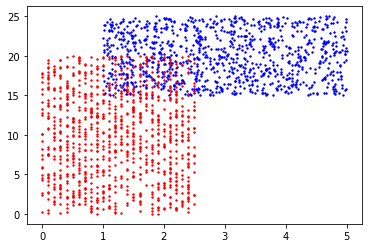

In [ ]:
f1,f2,y = generate_dataset(1000,0)
for i in range(len(y)):
  if y[i] == 0:
    plt.scatter(f1[i],f2[i],s=2,color = 'red')
  else:
    plt.scatter(f1[i],f2[i],s=2,color = 'blue')

In [ ]:
f1 = np.array(f1)
f2 = np.array(f2)
y = np.array(y)
features = np.zeros((f1.shape[0],2))
features[:,0] = f1[:]
features[:,1] = f2[:]
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1400, 2) (600, 2) (1400,) (600,)


In [ ]:
res = experiment_model(X_train,y_train,y,f1,f2,y_test,X_test)

SVM , Kernal = RBF , Best parameters: {'C': 10, 'gamma': 1}
SVM , Kernel = Linear ,Best parameters: {'C': 10}
SVM , Kernel = Poly , Best parameters: {'C': 1, 'degree': 2}
SVM , Kernel = Sigmoid , Best parameters: {'C': 0.1, 'gamma': 10}
SVM , Kernel = Manual, 


In [ ]:
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


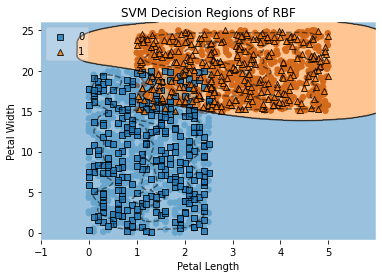

In [ ]:
# create the SVM classifier
clf = SVC(kernel='rbf', C=0.1, gamma=1)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of RBF')

# Show the plot
plt.show()

ACC is : 0.9047619047619048 
Rec is : 0.9375 
Persision is :  0.9047619047619048 
F1 Score is : 0.9208400646203555


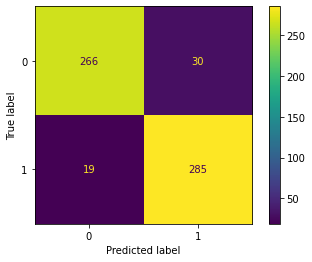

In [ ]:
show_metric(y_test,res[0][0])

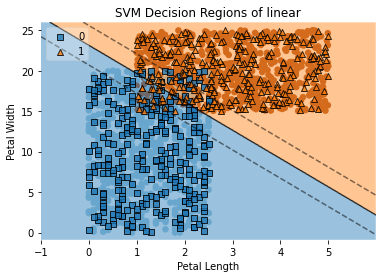

In [ ]:
# create the SVM linear classifier
clf = SVC(kernel='linear', C=10)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of linear')

# Show the plot
plt.show()

ACC is : 0.9022801302931596 
Rec is : 0.9111842105263158 
Persision is :  0.9022801302931596 
F1 Score is : 0.90671031096563


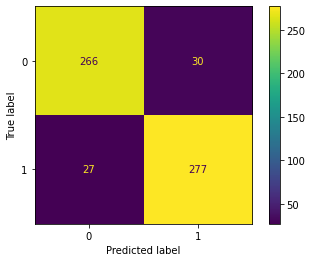

In [ ]:
show_metric(y_test,res[1][0])

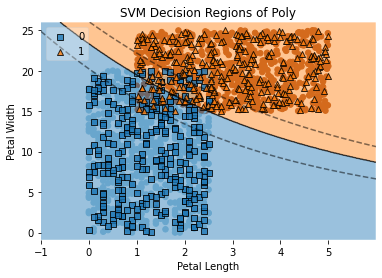

In [ ]:
# create the Poly classifier
clf = SVC(kernel='poly', C= 1, degree= 2)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of Poly')

# Show the plot
plt.show()

ACC is : 0.9072847682119205 
Rec is : 0.9013157894736842 
Persision is :  0.9072847682119205 
F1 Score is : 0.9042904290429044


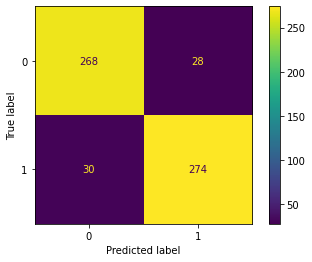

In [ ]:
show_metric(y_test,res[2][0])

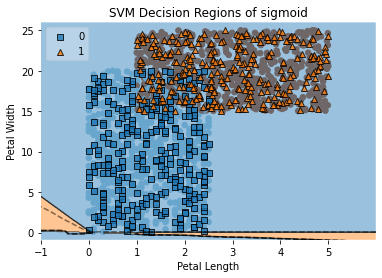

In [ ]:
# create the sigmoid classifier
clf = SVC(kernel='sigmoid', C= 0.1, gamma= 10)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of sigmoid')

# Show the plot
plt.show()

ACC is : 0.49333333333333335 
Rec is : 0.0 
Persision is :  0.0 
F1 Score is : 0.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


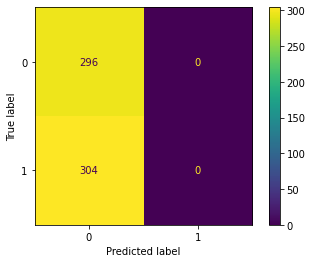

In [ ]:
show_metric(y_test,res[3][0])

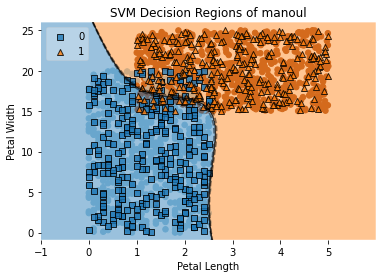

In [ ]:
# create the sigmoid classifier
clf = SVC(kernel=polynomial_kernel)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of manoul')

# Show the plot
plt.show()

ACC is : 0.9133333333333333 
Rec is : 0.944078947368421 
Persision is :  0.8913043478260869 
F1 Score is : 0.9169329073482427


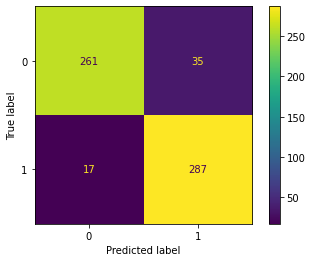

In [ ]:
show_metric(y_test,res[4][0])

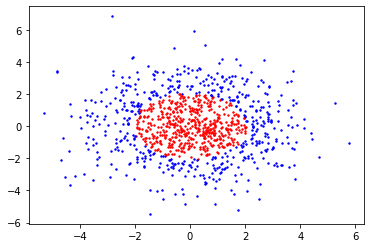

In [ ]:
f1,f2,y = generate_dataset(1000,1)
for i in range(len(y)):
  if y[i] == 0:
    plt.scatter(f1[i],f2[i],s=2,color = 'red')
  else:
    plt.scatter(f1[i],f2[i],s=2,color = 'blue')

In [ ]:
f1 = np.array(f1)
f2 = np.array(f2)
y = np.array(y)
features = np.zeros((f1.shape[0],2))
features[:,0] = f1[:]
features[:,1] = f2[:]
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(700, 2) (300, 2) (700,) (300,)


In [ ]:
res = experiment_model(X_train,y_train,y,f1,f2,y_test,X_test)

SVM , Kernal = RBF , Best parameters: {'C': 10, 'gamma': 0.1}
SVM , Kernel = Linear ,Best parameters: {'C': 0.1}
SVM , Kernel = Poly , Best parameters: {'C': 10, 'degree': 2}
SVM , Kernel = Sigmoid , Best parameters: {'C': 1, 'gamma': 0.1}
SVM , Kernel = Manual, 


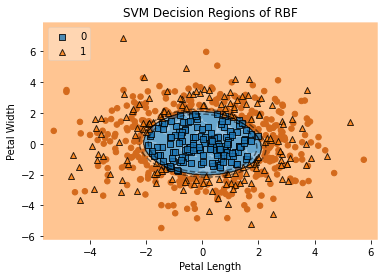

In [ ]:
# create the SVM classifier
clf = SVC(kernel='rbf', C=10, gamma=0.1)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of RBF')

# Show the plot
plt.show()

ACC is : 0.9866666666666667 
Rec is : 0.9866666666666667 
Persision is :  0.9866666666666667 
F1 Score is : 0.9866666666666668


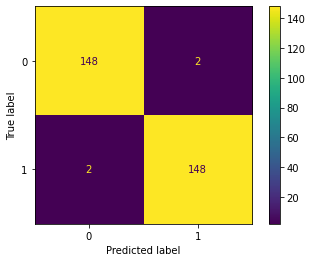

In [ ]:
show_metric(y_test,res[0][0])

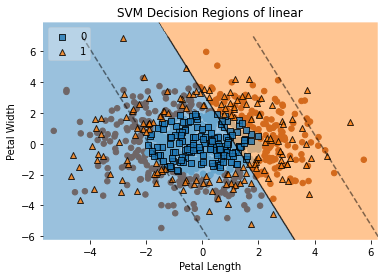

In [ ]:
# create the SVM linear classifier
clf = SVC(kernel='linear', C=10)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of linear')

# Show the plot
plt.show()

ACC is : 0.6166666666666667 
Rec is : 0.38666666666666666 
Persision is :  0.7160493827160493 
F1 Score is : 0.5021645021645021


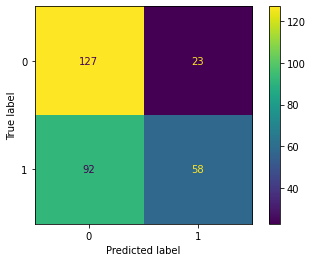

In [ ]:
show_metric(y_test,res[1][0])

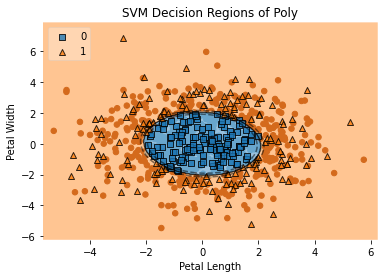

In [ ]:
# create the Poly classifier
clf = SVC(kernel='poly', C= 10, degree= 2)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of Poly')

# Show the plot
plt.show()

ACC is : 0.9833333333333333 
Rec is : 0.98 
Persision is :  0.9865771812080537 
F1 Score is : 0.9832775919732442


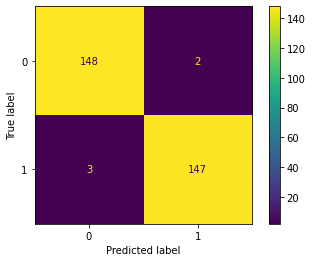

In [ ]:
show_metric(y_test,res[2][0])

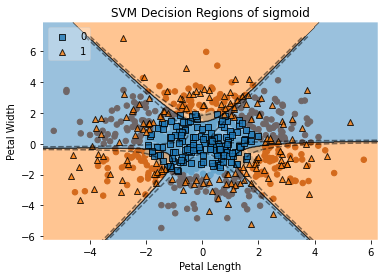

In [ ]:
# create the sigmoid classifier
clf = SVC(kernel='sigmoid', C= 1, gamma= 0.1)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of sigmoid')

# Show the plot
plt.show()

ACC is : 0.6833333333333333 
Rec is : 0.49333333333333335 
Persision is :  0.7956989247311828 
F1 Score is : 0.6090534979423868


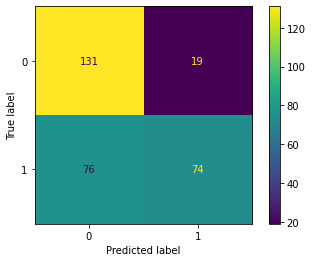

In [ ]:
show_metric(y_test,res[3][0])

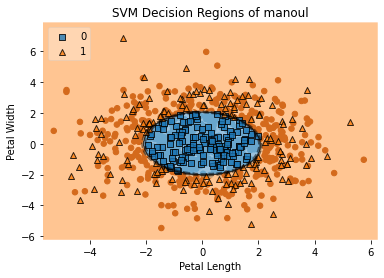

In [ ]:
# create the sigmoid classifier
clf = SVC(kernel=polynomial_kernel)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of manoul')

# Show the plot
plt.show()

ACC is : 0.9966666666666667 
Rec is : 0.9933333333333333 
Persision is :  1.0 
F1 Score is : 0.9966555183946488


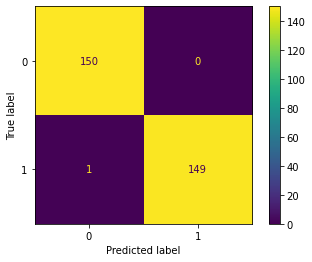

In [ ]:
show_metric(y_test,res[4][0])

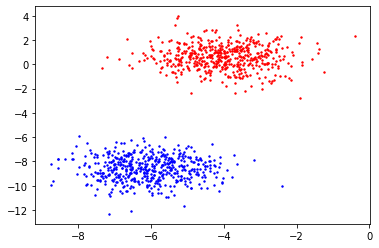

In [ ]:
f1,f2,y = generate_dataset(1000,2)
for i in range(len(y)):
  if y[i] == 0:
    plt.scatter(f1[i],f2[i],s=2,color = 'red')
  else:
    plt.scatter(f1[i],f2[i],s=2,color = 'blue')

In [ ]:
f1 = np.array(f1)
f2 = np.array(f2)
y = np.array(y)
features = np.zeros((f1.shape[0],2))
features[:,0] = f1[:]
features[:,1] = f2[:]
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(700, 2) (300, 2) (700,) (300,)


In [ ]:
res = experiment_model(X_train,y_train,y,f1,f2,y_test,X_test)

SVM , Kernal = RBF , Best parameters: {'C': 0.1, 'gamma': 0.1}
SVM , Kernel = Linear ,Best parameters: {'C': 0.1}
SVM , Kernel = Poly , Best parameters: {'C': 0.1, 'degree': 2}
SVM , Kernel = Sigmoid , Best parameters: {'C': 0.1, 'gamma': 0.1}
SVM , Kernel = Manual, 


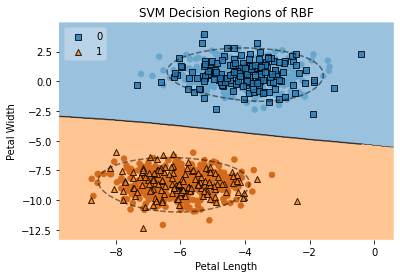

In [ ]:
# create the SVM classifier
clf = SVC(kernel='rbf', C=0.1, gamma=0.1)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of RBF')

# Show the plot
plt.show()

ACC is : 1.0 
Rec is : 1.0 
Persision is :  1.0 
F1 Score is : 1.0


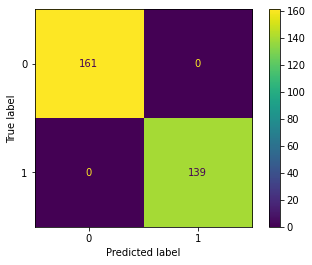

In [ ]:
show_metric(y_test,res[0][0])

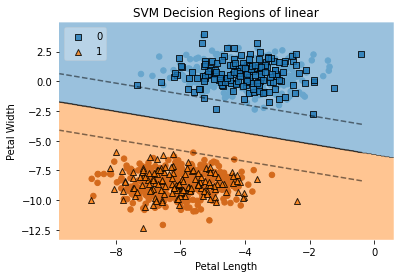

In [ ]:
# create the SVM linear classifier
clf = SVC(kernel='linear', C=0.1)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of linear')

# Show the plot
plt.show()

ACC is : 1.0 
Rec is : 1.0 
Persision is :  1.0 
F1 Score is : 1.0


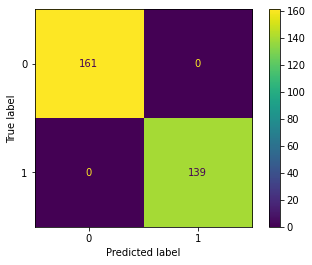

In [ ]:
show_metric(y_test,res[1][0])

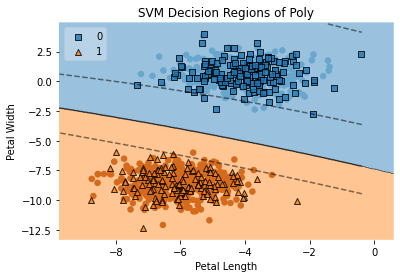

In [ ]:
# create the Poly classifier
clf = SVC(kernel='poly', C= 0.1, degree= 2)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of Poly')

# Show the plot
plt.show()

ACC is : 1.0 
Rec is : 1.0 
Persision is :  1.0 
F1 Score is : 1.0


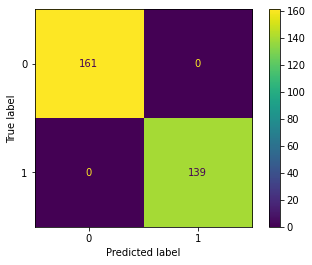

In [ ]:
show_metric(y_test,res[2][0])

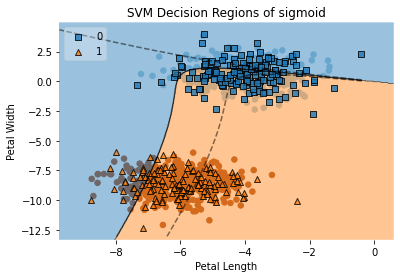

In [ ]:
# create the sigmoid classifier
clf = SVC(kernel='sigmoid', C= 0.1, gamma= 0.1)
clf.fit(X_train, y_train)



plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of sigmoid')

# Show the plot
plt.show()

ACC is : 0.61 
Rec is : 0.8273381294964028 
Persision is :  0.5528846153846154 
F1 Score is : 0.6628242074927955


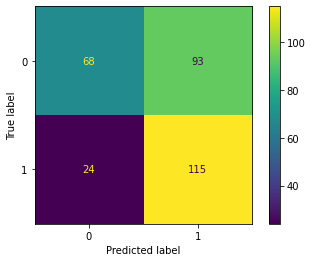

In [ ]:
show_metric(y_test,res[3][0])

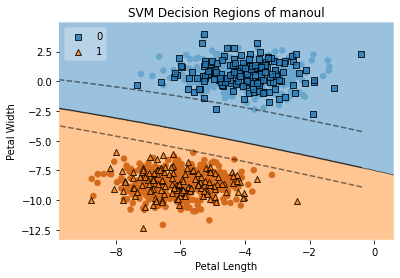

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay
# create the sigmoid classifier
clf = SVC(kernel=polynomial_kernel)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# ax = plt.gca()
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)

plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of manoul')

# # Show the plot
plt.show()

ACC is : 1.0 
Rec is : 1.0 
Persision is :  1.0 
F1 Score is : 1.0


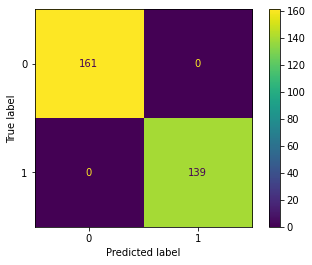

In [ ]:
show_metric(y_test,res[4][0])

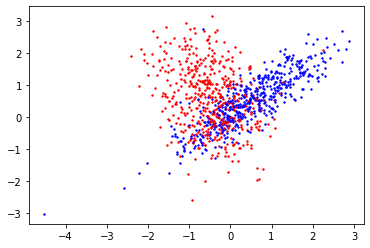

In [ ]:
f1,f2,y = generate_dataset(1000,3)
for i in range(len(y)):
  if y[i] == 0:
    plt.scatter(f1[i],f2[i],s=2,color = 'red')
  else:
    plt.scatter(f1[i],f2[i],s=2,color = 'blue')

In [ ]:
f1 = np.array(f1)
f2 = np.array(f2)
y = np.array(y)
features = np.zeros((f1.shape[0],2))
features[:,0] = f1[:]
features[:,1] = f2[:]
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(700, 2) (300, 2) (700,) (300,)


In [ ]:
res = experiment_model(X_train,y_train,y,f1,f2,y_test,X_test)

SVM , Kernal = RBF , Best parameters: {'C': 1, 'gamma': 1}
SVM , Kernel = Linear ,Best parameters: {'C': 0.1}
SVM , Kernel = Poly , Best parameters: {'C': 10, 'degree': 2}
SVM , Kernel = Sigmoid , Best parameters: {'C': 0.1, 'gamma': 0.1}
SVM , Kernel = Manual, 


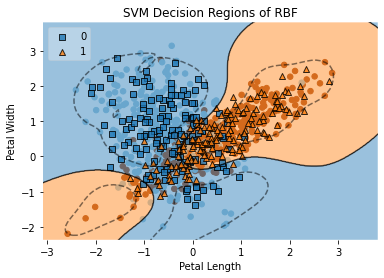

In [ ]:
# create the SVM classifier
clf = SVC(kernel='rbf', C=1, gamma=1)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of RBF')

# Show the plot
plt.show()

ACC is : 0.8 
Rec is : 0.7612903225806451 
Persision is :  0.8368794326241135 
F1 Score is : 0.7972972972972973


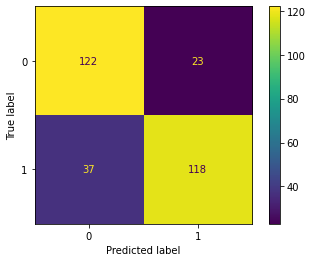

In [ ]:
show_metric(y_test,res[0][0])

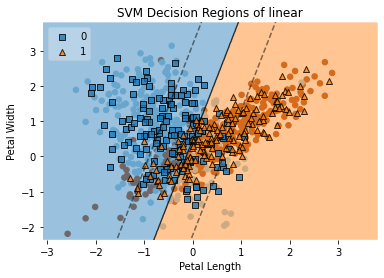

In [ ]:
# create the SVM linear classifier
clf = SVC(kernel='linear', C=0.1)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of linear')

# Show the plot
plt.show()

ACC is : 0.7666666666666667 
Rec is : 0.7741935483870968 
Persision is :  0.7741935483870968 
F1 Score is : 0.7741935483870968


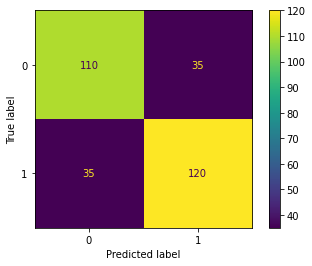

In [ ]:
show_metric(y_test,res[1][0])

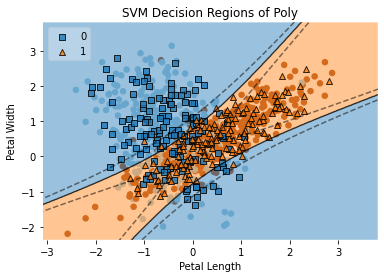

In [ ]:
# create the Poly classifier
clf = SVC(kernel='poly', C= 10, degree= 2)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of Poly')

# Show the plot
plt.show()

ACC is : 0.82 
Rec is : 0.9354838709677419 
Persision is :  0.7671957671957672 
F1 Score is : 0.8430232558139535


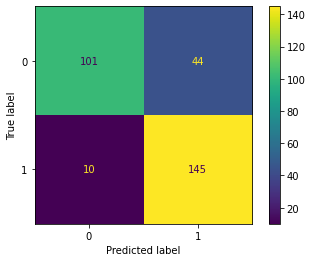

In [ ]:
show_metric(y_test,res[2][0])

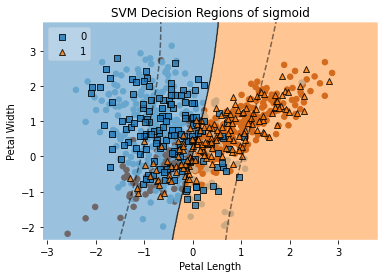

In [ ]:
# create the sigmoid classifier
clf = SVC(kernel='sigmoid', C= 0.1, gamma= 0.1)
clf.fit(X_train, y_train)



plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of sigmoid')

# Show the plot
plt.show()

ACC is : 0.75 
Rec is : 0.6967741935483871 
Persision is :  0.7941176470588235 
F1 Score is : 0.7422680412371135


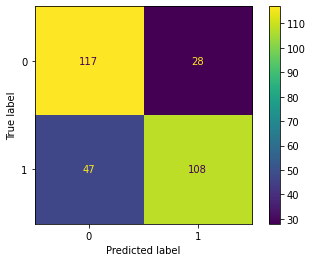

In [ ]:
show_metric(y_test,res[3][0])

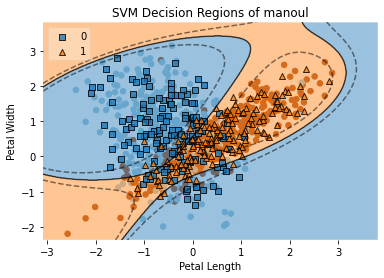

In [ ]:
# create the sigmoid classifier
clf = SVC(kernel=polynomial_kernel)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of manoul')

# Show the plot
plt.show()

ACC is : 0.82 
Rec is : 0.8709677419354839 
Persision is :  0.7988165680473372 
F1 Score is : 0.8333333333333334


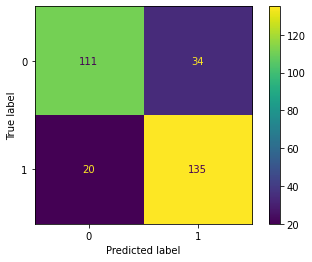

In [ ]:
show_metric(y_test,res[4][0])

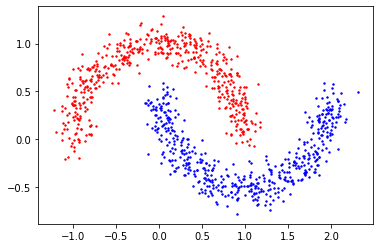

In [ ]:
f1,f2,y = generate_dataset(1000,4)
for i in range(len(y)):
  if y[i] == 0:
    plt.scatter(f1[i],f2[i],s=2,color = 'red')
  else:
    plt.scatter(f1[i],f2[i],s=2,color = 'blue')

In [ ]:
f1 = np.array(f1)
f2 = np.array(f2)
y = np.array(y)
features = np.zeros((f1.shape[0],2))
features[:,0] = f1[:]
features[:,1] = f2[:]
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(700, 2) (300, 2) (700,) (300,)


In [ ]:
res = experiment_model(X_train,y_train,y,f1,f2,y_test,X_test)

SVM , Kernal = RBF , Best parameters: {'C': 0.1, 'gamma': 10}
SVM , Kernel = Linear ,Best parameters: {'C': 1}
SVM , Kernel = Poly , Best parameters: {'C': 0.1, 'degree': 3}
SVM , Kernel = Sigmoid , Best parameters: {'C': 1, 'gamma': 0.1}
SVM , Kernel = Manual, 


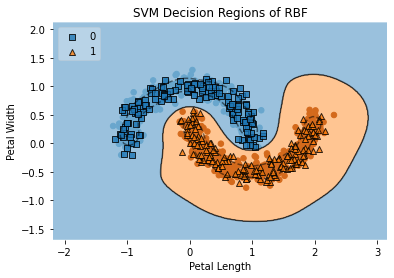

In [ ]:
# create the SVM classifier
clf = SVC(kernel='rbf', C=0.1, gamma=10)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of RBF')

# Show the plot
plt.show()

ACC is : 1.0 
Rec is : 1.0 
Persision is :  1.0 
F1 Score is : 1.0


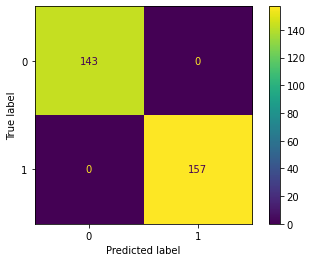

In [ ]:
show_metric(y_test,res[0][0])

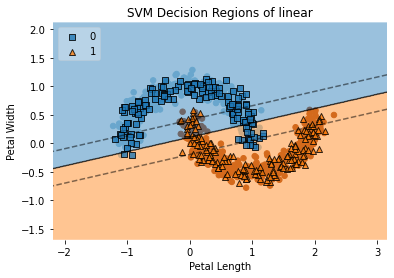

In [ ]:
# create the SVM linear classifier
clf = SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of linear')

# Show the plot
plt.show()

ACC is : 0.8633333333333333 
Rec is : 0.8726114649681529 
Persision is :  0.8670886075949367 
F1 Score is : 0.8698412698412699


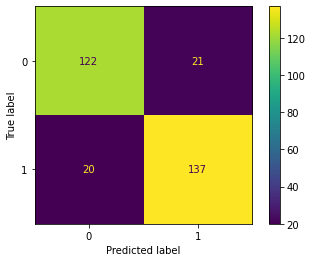

In [ ]:
show_metric(y_test,res[1][0])

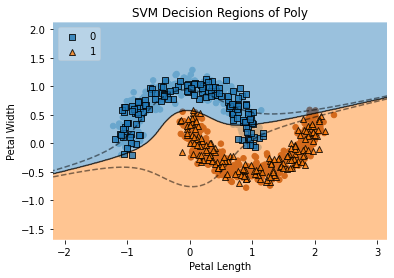

In [ ]:
# create the Poly classifier
clf = SVC(kernel='poly', C= 0.1, degree= 3)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of Poly')

# Show the plot
plt.show()

ACC is : 0.9366666666666666 
Rec is : 0.9936305732484076 
Persision is :  0.896551724137931 
F1 Score is : 0.9425981873111783


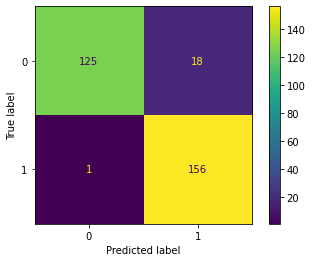

In [ ]:
show_metric(y_test,res[2][0])

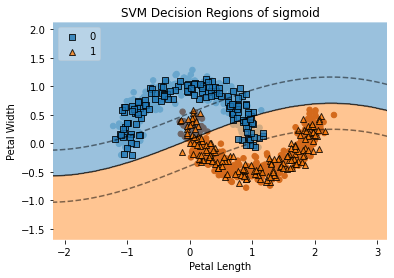

In [ ]:
# create the sigmoid classifier
clf = SVC(kernel='sigmoid', C= 1, gamma= 0.1)
clf.fit(X_train, y_train)



plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of sigmoid')

# Show the plot
plt.show()

ACC is : 0.8466666666666667 
Rec is : 0.8598726114649682 
Persision is :  0.8490566037735849 
F1 Score is : 0.8544303797468354


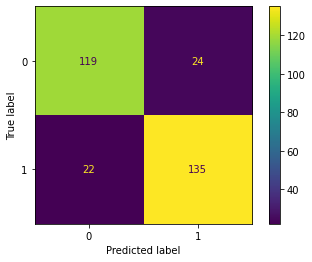

In [ ]:
show_metric(y_test,res[3][0])

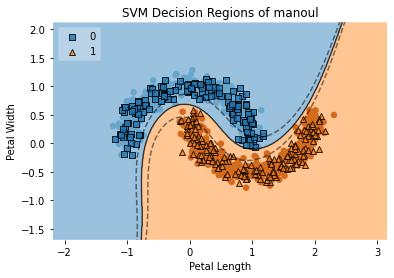

In [ ]:
# create the sigmoid classifier
clf = SVC(kernel=polynomial_kernel)
clf.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
# plot the decision function
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot decision regions
plot_decision_regions(X_test, y_test, clf=clf, 
                      legend=2, # place legend at upper left corner
)
# Add axis labels and a title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('SVM Decision Regions of manoul')

# Show the plot
plt.show()

ACC is : 1.0 
Rec is : 1.0 
Persision is :  1.0 
F1 Score is : 1.0


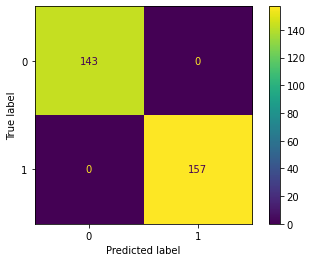

In [ ]:
show_metric(y_test,res[4][0])

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target


In [ ]:
X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

In [ ]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

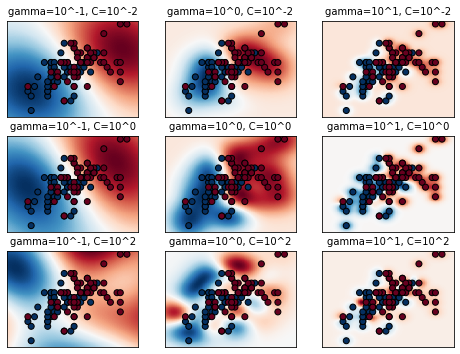

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for k, (C, gamma, clf) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

